In [1]:
import os
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops
import rasterio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
import pandas as pd

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config("base")

24-Dec-23 23:31:08 - INFO - Starting 'load_config'.
24-Dec-23 23:31:08 - INFO - Finished 'load_config' in 0.0216 secs.


In [3]:

def plot_cropped_images(images, titles, ncols=3):
    """Plot a list of loaded images.
    
    Args:
        images (list): List of loaded images.
        titles (list): List of titles for the images.
        ncols (int): Number of columns for the subplot grid.
    """
    nrows = len(images) // ncols + (len(images) % ncols > 0) # calculate number of rows

    plt.figure(figsize=(10, 10))
    plt.suptitle('Cropped Images', fontsize=18, y=0.95)

    for n, img in enumerate(images):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)
        # Plot raster crop
        ax.imshow(img)
        # chart formatting
        ax.set_title(os.path.basename(titles[n]), fontsize=8)
        ax.axis('off')
    plt.show()


def extract_color_histogram(image: np.ndarray, bins: int = 32) -> np.ndarray:
    """
    Extracts the color histogram from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.
    - bins (int): The number of bins for the histogram.

    Returns:
    - numpy.ndarray: The color histogram.
    """
    # Compute the histogram of the RGB channels separately
    rhist = cv2.calcHist([image], [0], None, [bins], [0, 256])
    ghist = cv2.calcHist([image], [1], None, [bins], [0, 256])
    bhist = cv2.calcHist([image], [2], None, [bins], [0, 256])

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([rhist, ghist, bhist])

    # Normalize the histogram
    cv2.normalize(hist_features, hist_features)
    logger.info(f'Color histogram shape: {hist_features.shape}')
    return hist_features


def extract_texture_features(image: np.ndarray) -> np.ndarray:
    """
    Extracts texture features from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The texture features.
    """
    # Convert the image to uint8
    image_uint8 = (image * 255).astype(np.uint8)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

    # Compute the GLCM of the grayscale image
    glcm = graycomatrix(gray_image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    # Compute texture features from the GLCM
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    # Concatenate the texture features into a single feature vector
    texture_features = np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation])
    
    # Normalize the texture features
    cv2.normalize(texture_features, texture_features)
    logger.info(f'Texture features shape: {texture_features.shape}')
    return texture_features


def extract_shape_features(image: np.ndarray, max_descriptors=10) -> np.ndarray:
    """
    Extracts shape features from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The shape features.
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Normalize the image to have a depth of 8 bits
    gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Initialize the SIFT feature extractor
    sift = cv2.xfeatures2d.SIFT_create()

    # Compute the SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # Ensure that the shape of descriptors is consistent
    # For example, you can take the first n descriptors if the shape is greater than n
    # Choose an appropriate number based on your needs
    if descriptors.shape[0] < max_descriptors:
        # If fewer descriptors than expected, pad with zeros
        pad_width = max_descriptors - descriptors.shape[0]
        descriptors = np.pad(descriptors, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
    elif descriptors.shape[0] > max_descriptors:
        # If more descriptors than expected, truncate
        descriptors = descriptors[:max_descriptors, :]

    # Normalize the descriptors
    cv2.normalize(descriptors, descriptors)

    logger.info(f'Shape features shape: {descriptors.shape}')
    return descriptors


def extract_geometric_features(rgb_image):
    """
    Extract geometric features from an RGB image of a leaf.

    Parameters:
    rgb_image (numpy.ndarray): RGB image of a leaf.

    Returns:
    numpy.ndarray: Array containing the geometric features.
    """
    # Convert RGB image to grayscale
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Get region properties from the binary mask
    props = regionprops(binary_mask)

    # Extract specific geometric features
    area = props[0].area
    perimeter = props[0].perimeter
    eccentricity = props[0].eccentricity
    extent = props[0].extent
    aspect_ratio = props[0].major_axis_length / props[0].minor_axis_length
    roundness = 4 * np.pi * area / (perimeter ** 2)
    compactness = area / props[0].convex_area

    # Combine features into a NumPy array
    geometric_features = np.array([area, perimeter, eccentricity, extent, aspect_ratio, roundness, compactness])

    cv2.normalize(geometric_features, geometric_features)

    logger.info(f'Geometric features shape: {geometric_features.shape}')
    return geometric_features


def preprocess_input(x):
    x = x.astype(np.float64)  # Convert the image to float64
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    x /= 255.0
    x = (x - mean) / std
    return x


def extract_resnet_features(img_data):
    # Load the pre-trained ResNet50 model
    base_model = models.resnet50(pretrained=True)
    
    # Remove the last layer (fully connected layer)
    base_model = nn.Sequential(*list(base_model.children())[:-1])
    
    # Add an adaptive average pooling layer
    base_model.add_module('GlobalAveragePooling', nn.AdaptiveAvgPool2d((1, 1)))
    
    # Convert the image data into a torch tensor, add a batch dimension, and transpose the image
    img_data = torch.from_numpy(img_data).unsqueeze(0).permute(0, 3, 1, 2)

    # Preprocess the image data
    img_data = preprocess_input(img_data)
    
    # Convert the image data into a torch tensor and add a batch dimension
    img_data = torch.from_numpy(img_data).unsqueeze(0)
    
    # Set the model to evaluation mode and extract features
    base_model.eval()
    with torch.no_grad():
        res_feature = base_model(img_data)
    
    # Remove the batch dimension and convert the tensor to a numpy array
    res_feature = res_feature.squeeze(0).numpy()
    
    return res_feature


def get_rgb_features(rgb_image):
    # Extract individual feature sets
    color_histogram = extract_color_histogram(rgb_image)
    texture_features = extract_texture_features(rgb_image)
    shape_features = extract_shape_features(rgb_image)
    geometric_features = extract_geometric_features(rgb_image)

    # Concatenate features into a single feature vector
    rgb_features = np.concatenate([color_histogram.flatten(), texture_features.flatten(), shape_features.flatten(), geometric_features.flatten()])

    # # Normalize the combined feature vector if necessary
    # combined_features = (combined_features - np.min(combined_features)) / (np.max(combined_features) - np.min(combined_features))
    logger.info(f'RGB features shape: {rgb_features.shape}')
    return rgb_features


def get_chm_features(chm_data):
    # Calculate basic statistics on the CHM data
    mean_height = np.mean(chm_data)
    max_height = np.max(chm_data)
    min_height = np.min(chm_data)
    height_range = max_height - min_height

    # Concatenate all features into a single vector
    chm_features = np.array([mean_height, max_height, min_height, height_range])
    logger.info(f'CHM features shape: {chm_features.shape}')
    return chm_features


def get_hyperspectral_features(hyperspectral_data):
    # Calculate mean and standard deviation for each spectral band
    mean_spectrum = np.mean(hyperspectral_data, axis=(1, 2))
    std_spectrum = np.std(hyperspectral_data, axis=(1, 2))

    # Concatenate all features into a single vector
    hyperspectral_features = np.concatenate((mean_spectrum, std_spectrum))
    logger.info(f'Hyperspectral features shape: {hyperspectral_features.shape}')
    return hyperspectral_features


def combine_features(rgb_features, hyperspectral_features, chm_features):
    # Combine features from all three sources into a single feature vector
    combined_features = np.concatenate((rgb_features, hyperspectral_features, chm_features), axis=0)
    logger.info(f'Combined features shape: {combined_features.shape}')
    return combined_features


def extract_label_from_filename(filename):
    # Extract the label from the filename
    return filename.split('_')[-2]


def extract_pid_from_filename(filename):
    # Extract the plot ID from the filename
    return filename.split('_')[0]

@utils.timer
def process_images(rgb_fns, chm_fns, hyps_fns):
    data = []
    # Iterate over all the image files
    for rgb_fn, chm_fn, hyps_fn in zip(rgb_fns, chm_fns, hyps_fns):
        logger.info(f'Processing {rgb_fn}...')
        # Load the images
        rgb_img = utils.load_rgb_images([rgb_fn])[0]
        chm_img = utils.load_grayscale_arrays([chm_fn])[0]
        hyps_img = utils.load_hyperspectral_rasters([hyps_fn])[0]

        # Extract features
        rgb_features = get_rgb_features(rgb_img)
        chm_features = get_chm_features(chm_img)
        hyps_features = get_hyperspectral_features(hyps_img)

        # Combine features
        combined_features = np.concatenate((rgb_features, hyps_features, chm_features), axis=0)

        # Extract label from filename
        label = extract_label_from_filename(rgb_fn)
        pid = extract_pid_from_filename(rgb_fn)

        # Create a DataFrame for the current image
        columns = ['pid', 'label'] + [f'f_{i}_{feature_type}' for feature_type, feature_set in [('rgb', rgb_features), ('hyps', hyps_features), ('chm', chm_features)] for i in range(len(feature_set))]
        image_data = [pid, label] + combined_features.tolist()
        image_df = pd.DataFrame([image_data], columns=columns)

        # Append the DataFrame to the main data list
        data.append(image_df)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(data, ignore_index=True)

    return df

In [4]:
conf = utils.load_config('base')
rgb_fns = utils.get_filenames(conf.data.path_pri, "png", 'rgb')
chm_fns = utils.get_filenames(conf.data.path_pri, "npy", 'chm')
hyps_fns = utils.get_filenames(conf.data.path_pri, "tif", 'hyps')
rgb_fns = sorted(rgb_fns)
chm_fns = sorted(chm_fns)
hyps_fns = sorted(hyps_fns)

24-Dec-23 23:31:08 - INFO - Starting 'load_config'.
24-Dec-23 23:31:08 - INFO - Finished 'load_config' in 0.0214 secs.


In [5]:
data = []

In [6]:
# rgb_fns = rgb_fns[:3]
# chm_fns = chm_fns[:3]
# hyps_fns = hyps_fns[:3]

rgb_fn = rgb_fns[0]
chm_fn = chm_fns[0]
hyps_fn = hyps_fns[0]

In [7]:
# for rgb_fn, chm_fn, hyps_fn in zip(rgb_fns, chm_fns, hyps_fns):
logger.info(f'Processing {rgb_fn}...')
# Load the images
rgb_img = utils.load_rgb_images([rgb_fn])[0]
logger.info(f'rgb_img shape: {rgb_img.shape}')
# chm_img = utils.load_grayscale_arrays([chm_fn])[0]
# logger.info(f'chm_img shape: {chm_img.shape}')
# hyps_img = utils.load_hyperspectral_rasters([hyps_fn])[0]
# logger.info(f'hyps_img shape: {hyps_img.shape}')
rgb_features = get_rgb_features(rgb_img)

24-Dec-23 23:31:08 - INFO - Processing ../data/03_primary/1000_rgb_unk_masked.png...
24-Dec-23 23:31:08 - INFO - Loaded RGB img shape: (87, 87, 3)
24-Dec-23 23:31:08 - INFO - rgb_img shape: (87, 87, 3)
24-Dec-23 23:31:08 - INFO - Color histogram shape: (96, 1)
24-Dec-23 23:31:08 - INFO - Texture features shape: (5, 4)
[ WARN:0@1.615] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736
24-Dec-23 23:31:08 - INFO - Shape features shape: (10, 128)
24-Dec-23 23:31:08 - INFO - Geometric features shape: (7,)
24-Dec-23 23:31:08 - INFO - RGB features shape: (1403,)


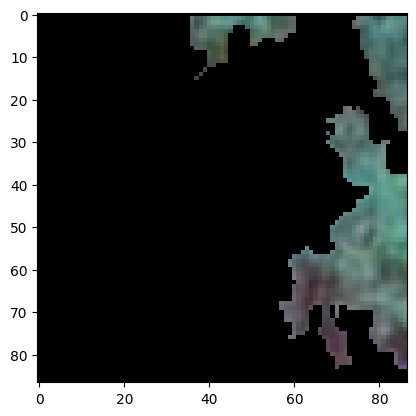

In [8]:
plt.imshow(rgb_img)
plt.show()

In [10]:
rgb_img.sum()

414277

In [19]:
rgb2 = utils.load_rgb_images(["../data/03_primary/1015_rgb_unk_masked.png"])[0]

25-Dec-23 00:24:47 - INFO - Loaded RGB img shape: (87, 87, 3)


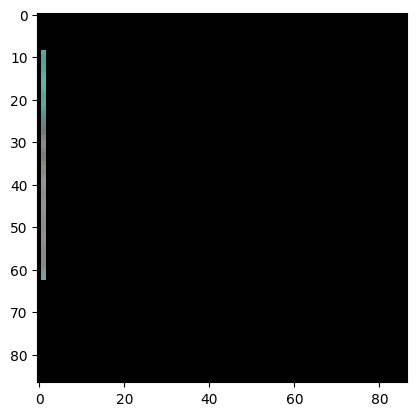

In [20]:
plt.imshow(rgb2)
plt.show()

In [26]:
def calculate_zero_pixel_percentage(rgb_image: np.ndarray) -> float:
    """
    Calculate the percentage of zero-value pixels in an RGB image.

    Args:
        rgb_image (np.ndarray): The input RGB image as a NumPy array with shape (height, width, 3).

    Returns:
        float: The percentage of pixels in the image that are completely black (0, 0, 0).
    """
    # Check if the image is empty or not an RGB image
    if rgb_image.size == 0 or len(rgb_image.shape) != 3 or rgb_image.shape[2] != 3:
        raise ValueError("Input is not a valid RGB image.")

    # Count the number of zero-value pixels
    zero_pixels = np.all(rgb_image == 0, axis=2)
    num_zero_pixels = np.count_nonzero(zero_pixels)

    # Calculate the total number of pixels
    total_pixels = rgb_image.shape[0] * rgb_image.shape[1]

    # Calculate the percentage of zero-value pixels
    zero_pixel_percentage = (num_zero_pixels / total_pixels) * 100

    return zero_pixel_percentage

In [27]:
calculate_zero_pixel_percentage(rgb_img)

82.24336107808165

In [28]:
calculate_zero_pixel_percentage(rgb2)

99.28656361474435

In [24]:
rgb2.flatten().shape

(22707,)

In [25]:
3 * 87**2

22707

In [22]:
rgb2.sum()

22452

In [ ]:

    # Iterate over all the image files
    
        # Extract features
        rgb_features = get_rgb_features(rgb_img)
        chm_features = get_chm_features(chm_img)
        hyps_features = get_hyperspectral_features(hyps_img)

        # Combine features
        combined_features = np.concatenate((rgb_features, hyps_features, chm_features), axis=0)

        # Extract label from filename
        label = extract_label_from_filename(rgb_fn)
        pid = extract_pid_from_filename(rgb_fn)

        # Create a DataFrame for the current image
        columns = ['pid', 'label'] + [f'f_{i}_{feature_type}' for feature_type, feature_set in [('rgb', rgb_features), ('hyps', hyps_features), ('chm', chm_features)] for i in range(len(feature_set))]
        image_data = [pid, label] + combined_features.tolist()
        image_df = pd.DataFrame([image_data], columns=columns)

        # Append the DataFrame to the main data list
        data.append(image_df)

In [33]:
df = pd.read_csv('../data/04_features/features.csv')

In [34]:
df.shape

(331, 1583)

In [35]:
df.head()

,pid,label,f_0_rgb,f_1_rgb,f_2_rgb,f_3_rgb,f_4_rgb,f_5_rgb,f_6_rgb,f_7_rgb,...,f_168_hyps,f_169_hyps,f_170_hyps,f_171_hyps,f_172_hyps,f_173_hyps,f_0_chm,f_1_chm,f_2_chm,f_3_chm
0,primary/1000,unk,0.020553,0.000000,0.000000,0.000000,0.000000,0.000003,0.000003,0.000096,...,0.652612,0.649662,0.471909,0.000000,0.000000,0.000000,0.006316,0.082213,0.0,0.082213
1,primary/1001,unk,0.010360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002346,0.010360,0.0,0.010360
2,primary/1002,unk,0.019529,0.000000,0.000000,0.000000,0.000003,0.000014,0.000049,0.000088,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000560,0.019529,0.0,0.019529
3,primary/1005,unk,0.017803,0.000008,0.000010,0.000013,0.000023,0.000058,0.000078,0.000131,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,primary/1006,unk,0.003915,0.000000,0.000012,0.000048,0.000110,0.000216,0.000268,0.000484,...,0.251059,0.253447,0.253123,0.253309,0.249956,0.240173,0.001285,1.000000,0.0,1.000000


In [32]:
df.label.value_counts()

unk         293
Xanthium     13
xan          13
other         8
Datura        2
dat           2
Name: label, dtype: int64